In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from datetime import datetime
from utils import *

seed = 265
torch.manual_seed(seed)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


# Introduction

In this assignment we will go through 3 types of unsupervised neural network: AutoEncoder (AE), Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN). In the first section we will also introduce a new type of layer: the transpose convolution as it is widely used in these unsupervised methods.

Unsupervised have many advantages including the fact that they don't need labels but they are also harder to train. It is normal if you don't get good results.

## Contents

1. Transpose convolution
2. AutoEncoder
3. Variational AutoEncoder
4. GAN

## Related videos from the curriculum

- [Lecture 15.1 — From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69)
- [Lecture 15.2 — Deep autoencoders](https://www.youtube.com/watch?v=6jhhIPdgkp0&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=70) 
- [Lecture 15.3 — Deep autoencoders for document retrieval](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71)
- [Lecture 15.6 — Shallow autoencoders for pre training](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74)
- [Lecture 13 | Generative Models](https://www.youtube.com/watch?v=5WoItGTWV54)


## 4. GAN

## Related videos from the curriculum

- [Lecture 13 | Generative Models](https://www.youtube.com/watch?v=5WoItGTWV54) (From 50:00 to 1:17:00)

In [2]:
data_train, _, _ = load_MNIST(label_list=[3])

Size of the training dataset:  5522
Size of the validation dataset:  609
Size of the test dataset:  1010


In [3]:
# Data too complex...
imgs_train = [F.max_pool2d(img,2) for img, _ in data_train]

### Defining a discriminator and a generator

In [ ]:
class MyDiscriminator(nn.Module):
    """
    Distinguish between fake (0) and real (1) images.
    
    It takes as input 10x10 black and white images and return a float
    determining (hopefully correctly) if images are real (1) or fake (0)
    """

    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear(in_features=10*10, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=1)
        
    def forward(self, x):
        N = x.shape[0]
        out = x.view(N, -1)
        out = F.leaky_relu(self.fc1(out), 2)
        out = F.leaky_relu(self.fc2(out), 2)
        out = torch.sigmoid(self.fc3(out))
        return out

class MyGenerator(nn.Module):
    """
    Generate fake images that look real from random noise
    
    It takes as input random normal noise (vectors of dimension z_dim) 
    and it returns a 10x10 black and white generated images (0) that will 
    hopefully be classified as real (1) by the discriminator. (So we hope that
    the discriminator will misclassify these generated images)
    """

    def __init__(self, z_dim):
        super().__init__() 
        self.fc1 = nn.Linear(z_dim, 5*5)
        self.transconv1 = nn.ConvTranspose2d(in_channels=1, out_channels=10,  kernel_size=3, stride=1)
        self.transconv2 = nn.ConvTranspose2d(in_channels=10, out_channels=1,  kernel_size=4, stride=1)
        
    def forward(self, x):
        N, z_dim = x.shape
        out = F.leaky_relu(self.fc1(x))
        out = out.view(N, 1, 5, 5)
        out = F.leaky_relu(self.transconv1(out))
        out = torch.sigmoid(self.transconv2(out))
        return out


### Training functions

At each iteration of the training loop of a GAN, we need to update both the discriminator and the generator. To do so, we can define 2 auxiliary functions
``train_discriminator_aux`` and ``train_generator_aux`` that will be called in the main training loop ``training_gan``.

#### Training the discriminator

The training step for the discriminator can be divided into 4 steps:
1. Compute classification loss on real images
2. Generate fake images
3. Compute classification loss on generated images
4. Update step for the discriminator

The discriminator loss is then the sum of 2 terms:
- the loss on real images, computed by classifying a batch of real images
- the loss on fake images, computed by classifying a batch of fake images, generated by the generator


#### Training the generator

The training step for the discriminator can be divided into 3 steps:
1. Generate fake images
2. Compute (mis)classification loss on generated images
3. Update step for the generator

--------------------
## TODO

Complete the 3 functions below

In [4]:
def train_discriminator_aux(true_images, generator, discriminator, optimizer_d, loss, z_dim, device=None):
    """
    Update step for the discriminator
    
    The discriminator loss is the sum of 2 terms:
    - the loss on real images, computed by classifying a batch of real images
    - the loss on fake images, computed by classifying a batch of fake images, 
    generated by the generator
    """
    discriminator.train()
    N = true_images.shape[0]

    # The grad might not be clean because of the train_generator_aux function
    optimizer_d.zero_grad()

    # ----------- Compute classification loss on real images -----------
    
    # Let the discriminator classify the real images
    true_preds = discriminator(true_images)
    # The targets are "ones" because the images are real
    true_targets = torch.ones(N, 1, device=device)
    # Compute discriminator loss on true images:
    # "how well the discriminator classifies *real* images as *real*"
    true_loss = F.binary_cross_entropy(true_preds, true_targets)
    true_score = torch.mean(true_preds)
    
    # ------------------- Generate fake images -------------------------
    
    # Generate a batch of normal noise, of dimension z_dim
    z = torch.randn(N, z_dim, device=device)
    # Use the generator to generate fake images from noise
    generator.eval()
    generated_images = generator(z)
    
    # ------- Compute classification loss on generated images ----------
    
    # Let the discriminator classify the real images
    generated_preds = discriminator(generated_images)
    # The targets are "zeros" because the images are fake
    generated_targets = torch.zeros(N, 1, device=device)
    # Compute discriminator loss on fake images:
    # "how well the discriminator classifies *fake* images as *fake*"
    generated_loss = loss(generated_preds, generated_targets)
    generated_score = torch.mean(1-generated_preds)

    # --------------- Update step for the discriminator ----------------
    loss_d = true_loss + generated_loss
    loss_d.backward()
    optimizer_d.step()
    optimizer_d.zero_grad()

    return loss_d, true_score, generated_score

def train_generator_aux(generator, discriminator, optimizer_g, loss, z_dim, N=256, device=None): 
    """
    Update step for the generator.
    
    The generator loss function is computed by classifying a batch of fake 
    images but using 1 (real) as target. The objective is then to minimize
    the number of fake images correctly classified as fake by the discriminator.
    """
    generator.train()
    # The grad might not be clean because of the train_discriminator_aux function
    optimizer_g.zero_grad()
    
    # ------------------- Generate fake images -------------------------
    
    # Generate a batch of normal noise, of dimension z_dim
    z = torch.randn(N, z_dim, device=device)
    # Use the generator to generate fake images from noise
    generated_images = generator(z)
    
    # ----- Compute (mis)classification loss on generated images -------
    
    discriminator.eval()
    # Let the discriminator (mis)classify the fake images
    preds = discriminator(generated_images)
    # The label is 0 (generated) but we want the discriminator to say 1
    targets = torch.ones(N, 1, device=device)
    # Compute generator loss on fake images:
    # "how well the generator fools the discriminator"
    # in other words "how well the generator makes the discriminator
    # misclassify fake images as true images"
    loss_g = loss(preds, targets)
    
    # ------------------ Update step for the generator -----------------
    
    loss_g.backward()
    optimizer_g.step()
    optimizer_g.zero_grad()
    
    return loss_g

def training_gan(z_dim, n_epochs, optimizer_g, optimizer_d, generator, discriminator, loss, train_loader, device=None):
    """
    Training loop that updates the discriminator and the generator at each iteration
    """
    if device is None:
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

    for epoch in range(1,n_epochs+1):

        loss_generator = 0.
        loss_discriminator = 0.
        scores_generated = 0.
        scores_true = 0.

        for true_images in train_loader:

            true_images = true_images.to(device=device)

            # Train the discriminator 
            loss_d, score_true, score_generated = train_discriminator_aux(
                true_images, generator, discriminator, optimizer_d, loss, z_dim, device=device
            )
            
            # Train the generator
            loss_g = train_generator_aux(
                generator, discriminator, optimizer_g, loss, z_dim, N=2048, device=device
            )

            loss_discriminator += loss_d
            loss_generator += loss_g
            scores_generated += score_generated
            scores_true += score_true
            
        if epoch % 10 == 0:
            print('{}  |  Epoch {}\nGenerator loss {:.4f}  |  Discriminator loss {:.4f}  |  Score true {:.4f}  |  Score generated {:.4f}'.format(
                datetime.now().strftime("%H:%M:%S"), 
                epoch,
                loss_generator / (len(train_loader)),
                loss_discriminator / len(train_loader),
                scores_true / len(train_loader),
                scores_generated / len(train_loader),
            ))

### Training your GAN

Run the cell below to train your GAN.
Keep in mind that training unsupervised model is not easy and that it is okay in this assignment if you don't get good results at all.

In [5]:
z_dim = 15

generator = MyGenerator(z_dim=z_dim)
generator.to(device=device)

discriminator = MyDiscriminator()
discriminator.to(device=device)

loss_fn = torch.nn.BCELoss()
train_loader_imgs = DataLoader(imgs_train, batch_size=512, shuffle=True)

lr_g = 0.001
lr_d = 0.0001
optimizer_g = optim.Adam(generator.parameters(), lr=lr_g)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d)

training_gan(
    z_dim = z_dim,
    n_epochs=400,
    optimizer_g=optimizer_g, 
    optimizer_d=optimizer_d, 
    generator=generator,
    discriminator=discriminator, 
    loss=loss_fn,
    train_loader=train_loader_imgs, 
    device=device
)

11:32:22  |  Epoch 10
Generator loss 1.0840  |  Discriminator loss 0.8056  |  Score true 0.7016  |  Score generated 0.6535
11:32:22  |  Epoch 20
Generator loss 1.1269  |  Discriminator loss 0.8809  |  Score true 0.6676  |  Score generated 0.6662
11:32:23  |  Epoch 30
Generator loss 1.2012  |  Discriminator loss 0.6042  |  Score true 0.8442  |  Score generated 0.6751
11:32:23  |  Epoch 40
Generator loss 1.7490  |  Discriminator loss 0.6611  |  Score true 0.7322  |  Score generated 0.7816
11:32:24  |  Epoch 50
Generator loss 0.9063  |  Discriminator loss 0.9108  |  Score true 0.7740  |  Score generated 0.5713
11:32:24  |  Epoch 60
Generator loss 1.1428  |  Discriminator loss 1.0069  |  Score true 0.6729  |  Score generated 0.6290
11:32:25  |  Epoch 70
Generator loss 1.4644  |  Discriminator loss 0.8213  |  Score true 0.7135  |  Score generated 0.7073
11:32:25  |  Epoch 80
Generator loss 1.8191  |  Discriminator loss 0.7062  |  Score true 0.7365  |  Score generated 0.7996
11:32:26  |  Epo

### Generate images

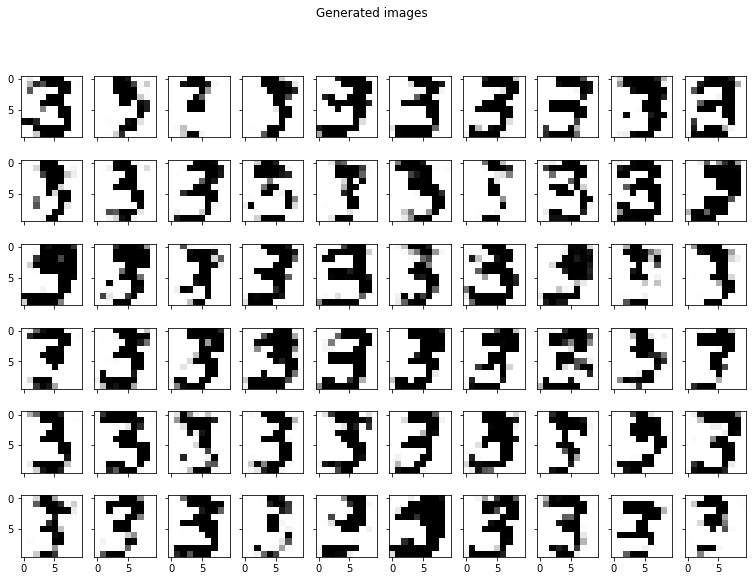

In [6]:
generator.eval()
generator.cpu()
N_img = 6*10

fig, axs = plt.subplots(nrows=6, ncols=10, figsize=(13,9), sharex=True, sharey=True)
fig.suptitle("Generated images")
for i in range(N_img):
    with torch.no_grad():
        # Generate random noise
        a_z = torch.randn(1, z_dim)
        # Create fake image from this noise
        a_img = generator(a_z)
        axs.flat[i].imshow(a_img[0].permute(1, 2, 0), cmap='Greys')
        
plt.show()

### Original images

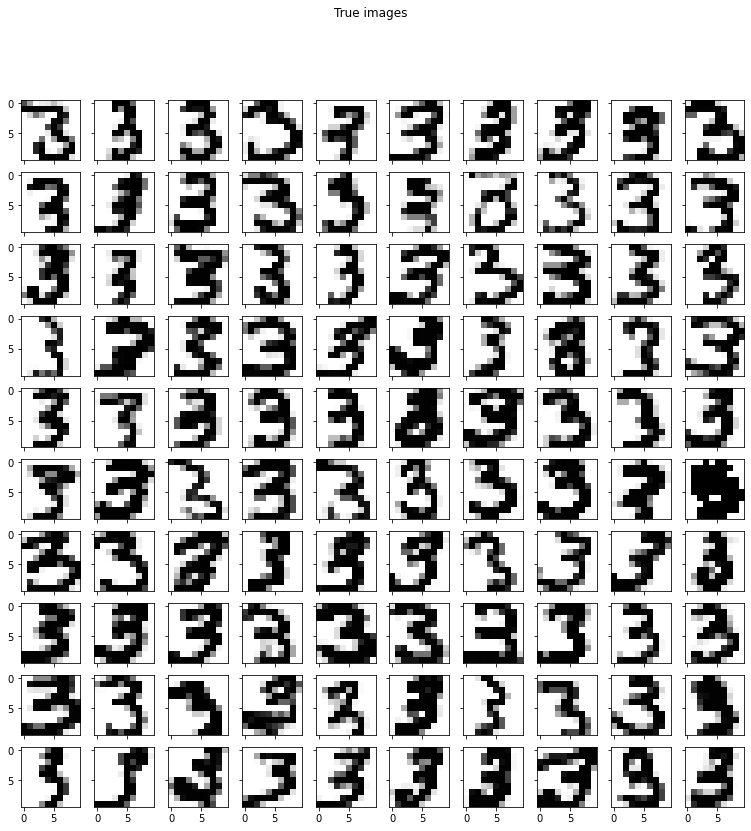

In [7]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(13,13), sharex=True, sharey=True)
fig.suptitle("True images")
for i in range(100):
    axs.flat[i].imshow(imgs_train[i].permute(1, 2, 0), cmap='Greys')
plt.show()

### Example generation
![Example of GAN generation (see GAN_generation image)](GAN_generation.png)

--------------------
## TODO
Analyse the results in the image above.

1. Comment the behavior of the GAN when generating different digits. Do they seem to have different characteristics (not always the exact same shape)? Do they look like the original images? 